# Maximum Likelihooh algorithm for Amplitude Estimation (MLAE)

In notebook **03_AmplitudeAmplification_Procedure** the **Amplification Amplitude** procedure for calculating $E_{x\sim p}(f)$ was reviewed. As showed, in order to take advantage of this procedure, a **Quantum Phase Estimation** (**QPE**) algorithm that relies in the inverse of the **Quantum Fourier Transform** ($\mathcal{QFT}$) is needed. Quantum circuit implementation of $\mathcal{QFT}$ are very complex and very long and deep so its use in actual quantum computers is noisy and not very useful.  

% Present notebook reviews an **amplitude amplification** algorithm that does not rely in $\mathcal{QFT}^{-1}$: the **Maximum Likelihood Amplitude Estimation** algorithm (**MLAE**).

In order to use this algorithm the following operators are needed:

* $\mathcal{P}$ for loading probability distribution $p(x)$
* $\mathcal{F}$ for loading a function $f(x)$

Present notebook and module are based on the following references:

* *Suzuki, Y., Uno, S., Raymond, R., Tanaka, T., Onodera, T., & Yamamoto, N.*. Amplitude estimation without phase estimation. Quantum Information Processing, 19(2), 2020. https://arxiv.org/abs/1904.10246

* NEASQC deliverable: *D5.1: Review of state-of-the-art for Pricing and Computation of VaR https://www.neasqc.eu/wp-content/uploads/2021/06/NEASQC_D5.1_Review-of-state-of-the-art-for-Pricing-and-Computation-of-VaR_R2.0_Final.pdf*

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
%matplotlib inline
%load_ext qat.core.magic

The qat.core.magic extension is already loaded. To reload it, use:
  %reload_ext qat.core.magic


In [4]:
global_qlmaas = True
try:
    from qlmaas.qpus import LinAlg
except (ImportError, OSError) as e:
    global_qlmaas = False
from qat.qpus import PyLinalg

In [5]:
def get_qpu(qlmass=False):
    """
    Function for selecting solver. User can chose between:
    * LinAlg: for submitting jobs to a QLM server
    * PyLinalg: for simulating jobs using myqlm lineal algebra.

    Parameters
    ----------

    qlmass : bool
        If True  try to use QLM as a Service connection to CESGA QLM
        If False PyLinalg simulator will be used

    Returns
    ----------
    
    lineal_qpu : solver for quantum jobs
    """
    if qlmass:
        if global_qlmaas:
            print('Using: LinAlg')
            linalg_qpu = LinAlg()
        else:
            raise ImportError("""Problem Using QLMaaS.Please create config file or use mylm solver""")
            
    else:
        print('Using PyLinalg')
        linalg_qpu = PyLinalg()
    return linalg_qpu

In [6]:
#QLMaaS == False -> uses PyLinalg
#QLMaaS == True -> try to use LinAlg
QLMaaS = True
linalg_qpu = get_qpu(QLMaaS)

Using: LinAlg


In [7]:
sys.path.append("../../")

## 1. Creating base gate for Grover-like operator

First we need to discretized the probability $p(x)$ and the function $f(x)$.

In [8]:
from my_lib.utils import  get_histogram, postprocess_results, run_job, test_bins

In [9]:
def p(x):
    return x*x
def f(x):
    return np.sin(x)

In [10]:
#number of Qbits for the circuit
n_qbits = 4
#The number of bins 
m_bins = 2**n_qbits
LowerLimit = 0.0
UpperLimit = 1.0 

X, p_X = get_histogram(p, LowerLimit, UpperLimit, m_bins)
f_X = f(X)

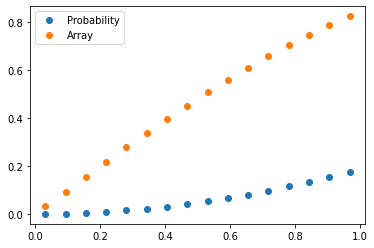

In [11]:
%matplotlib inline
plt.plot(X, p_X, 'o')
plt.plot(X, f_X, 'o')
plt.legend(['Probability', 'Array'])

Now we create the correspondent operators $\mathcal{P}$ and $\mathcal{F}$ and their correspondent composition.

In [12]:
from my_lib.data_loading import load_probability, load_array, load_pf

In [13]:
p_gate = load_probability(p_X)
f_gate = load_array(np.sqrt(f_X))
pf_gate = load_pf(p_gate, f_gate)

In [14]:
#circuit = Qprog.to_circ()
%qatdisplay pf_gate --depth 0

The $\mathcal{PF}$ operator is what we need for creating the Groover-like operator. 

## 2. ML-QPE algorithm step by step.

The main problem is the following: We have an **Groover** like operator, $\hat{Q}$ which is equivalent to a rotation around **y-axis** of a $\theta$ angle. This angle is unknow (a priori) and we want to compute it. We know that using **QPE** with **QFT** allows us get the angle but we know too that **QFT** is a complex and a prone error operation for a quantum computer. Usign the **MLAE** we can obtain this $\theta$ without using a **QFT**.

We have implemented and python class called **MaximumLikelihoodAE** (in the script **maximum_likelihood_ae.py**) that allows us implement the **MLAE** algorithm. In this section we are going to describe the class step by step and explain the basics of the **MLAE** algorithm

### Calling the *MaximumLikelihoodAE*  class

In [18]:
#import the class
from my_lib.maximum_likelihood_ae import MLAE

For creating the *class* is mandatory provide a python dictionary. The keys of this are defined below (in section *4.1*). In this section the mandatory keys will be used:

* oracle: this key contains the (mandatory) base operator for creating the Groover-like one (in our case $\mathcal{PF}$).
* qpu: this is the qpu solver. If not provide (or provide a None) then the class try to create a QLM PyLinal solver. It is recomended provided the solver.

In [ ]:
#Instantitate the class with the program and the Q operator
#Number of measurements of the last qbit will be done. 0 calculates the true probability
nbshots = 0
arg_dictionary = {
    'oracle': pf_gate,
    'qpu': linalg_qpu,
}
ml_ae = MLAE(**arg_dictionary)

By instantiate the **MaximumLikelihoodAE** the class create following properties:

* *q_prog*: this property stores the QLM program for using base gate $\mathcal{PF}$ 
* *q_gate*: this propety stores the correspondient Grover-like operator for $\mathcal{PF}$


In [ ]:
print('QLM loading program')
circuit = ml_ae.q_prog.to_circ()
%qatdisplay circuit --depth 1

In [ ]:
print('Grover-like Operator')
q_gate = ml_ae.q_gate
%qatdisplay q_gate --depth 1

### Apply Grover-like operator $m_k$ times

In order to explain the **MLAE** algorithm first we are going to apply the Grover-like operator (property **q_gate** of the class) a given number of times $m_k$ over the quantum program with the probability $p(x)$ and the function $f(x)$ loaded (property **q_prog** of the class. 

We are going to create the correspondient circuit and job and obtain the results of the simulation. This can be done using the **run_step** method of the class. This method need:

* m_k: the number of times the Grover-like operator will be applied
* nbshots : number of executions for the QLM simulation (0 for calculating True probabilities). If nbshots is not given default nbshots of the class will be used.

The method returns:
* pdf: pandas DataFrame with the results properly formated for maximum likelihood calculations
* circuit: generated circuit
* job: generated job

In [ ]:
#number of times operator Q should be applied
m_k = 4
pdf, circuit, job= ml_ae.run_step(m_k)

In [ ]:
pdf

The resulting pdf provides following info:

* **Probability_|0>**: Probability for obtaining state $|0\rangle$. If nbshots = 0 then is the true probabilitiy computed. Otherwise it is its frequency.
* **Probability_|1>**: Probability for obtaining state $|1\rangle$. If nbshots = 0 then is the true probabilitiy computed otherwise it is its frequency.
* **m_k**: number of operator $\hat{Q}$ was applied.
* **h_k**: number of times the state $|1\rangle$ were obtained. If nbshots = 0 then is computed by multiply 100\*Probability_|1> (can be changed using the property: **default_nbshots**). Otherwise It is the propper number of times state $|1\rangle$  was obtained.
* **n_k**: number of measurements done. If nbshots = 0 then n_k=100 (can be changed using the property: **default_nbshots**). Otherwise it will be equal to nbshots


**NOTE**

The *run_step* method creates a deep copy of the *q_prog* property each time is called, so the original *q_prog* property do not suffer any modification

In [ ]:
circuit = ml_ae.q_prog.to_circ()
%qatdisplay circuit --depth 1

### Calculating **likelihood**

With the info of the resulting pandas DataFrame (pdf) we can compute the asociated **Likelihood**. 

What is the **Likelihood**?

In this case we have applied the operator $\hat{Q}^{m_k}$. As we know this operator is equivalent to a rotation around the y axis of $(2m_k+1)\theta$. Finally we have done several measurements of the last qbit and we have obtained some statistics (that are stored in pdf). 
In this case the **Likelihood** is the probability of obtaining the given measurements conditioned to a fixed angle $\theta$. In the case of our **Groover** operator the **Likelihood** for $m_k$ measurements of the state $|1\rangle$ when $n_k$ measurements were done will be:

$$l_{k}(h_k/\theta) = (\sin^2[(2*m_k+1)\theta])^{h_k}(\cos^2[(2*m_k+1)\theta])^{n_k-h_k}$$

This is because the probability of the state $|1\rangle$ is given by $\sin^2[(2*m_k+1)\theta]$ the probability of the state $|0\rangle$ is given by: $\cos^2[(2*m_k+1)\theta]$ and each measurment is independent of the other measurements (so a binomial distribution can be used)

For computing purpouses, usually, instead of the **Likelihood** the minus logarithm of the **Likelihood** is provided:

$$-\ln{l_{k}(h_k/\theta)} = -2h_k\ln(\sin[(2*m_k+1)\theta])-2(N_k-h_k)\ln(\cos[(2*m_k+1)\theta])$$

For computing the logarithm of the **Likelihood** we use the method **launch_likelihood** that needs:
* **pdf_input**: pandas DataFrame obtained from *run_step* method
* **n_theta**: that is the number of divisions of the domain (basically we are going to compute the log of **Likelihood** of the measurements of the pdf for several angles. n_theta is the number of angles we are going to use). 

The output of the method is a new pdf with different $\theta$ angles and the correspondent log **Likelihood** for getting the given measurements of the pdf


In [ ]:
likelihood_ = ml_ae.launch_likelihood(pdf, n_theta=100)

We can plot the **Likelihood** with respect the posible $\theta$.

In [ ]:
plt.plot(likelihood_['theta'], likelihood_['l_k'], '-o')
plt.xlabel('theta')
plt.ylabel('Likelihood')

As can be seen there are some values of $\theta$ where the **-log of Likelihood** presents a minimums. We expect that the $\theta$ we are looking for would be one of these values 

## 3. ML-QPE algorithm 

With the before section we can know complete the **ML-QPE** algorithm:

1. Select a list  of different $m_k$ applications of the **Groover** like operator (one posible option will be for example:  $k=0,1,2,3...$ $m_k=1,4,8,16...$).
2. For each $m_k$ apply the **Groover** like operator and meas the last qbit of the circuit a fixed number of times ($n_k$) and get the number of state $|1\rangle$ measurements ($h_k$).
3. For eack $m_k$ the associated **Likelihood** will be:
$$l_{k}(h_k/\theta) = (\sin^2[(2*m_k+1)\theta])^{h_k}(\cos^2[(2*m_k+1)\theta])^{n_k-h_k}$$
4. So for each $m_k$ we have a $n_k$ and a $h_k$ and a associated **Likelihood** $l_k$. So we can compute the final **Likelihood** as:
$$L(\mathbf{h}/\theta) = \prod_{k=0}^{M}{l_{k}(h_k/\theta)}$$
$$\mathbf{h} = (h_0, h_1,...,h_M)$$
5. The idea is find the $\theta_{a}$ that maximizes the total **Likelihood**
$$\theta_{a} = arg \ max {L(\mathbf{h}/\theta)}$$ 

Maximizing **Likelihood** is equivalent to minimize the **- the logarithm of the Likelihood**. Usually this is preferred over the former so we are going to:


$$\theta_{a} = arg \ min \sum_{k=0}^{M} \Big( -2h_k\ln(\sin[(2*m_k+1)\theta])-2(N_k-h_k)\ln(\cos[(2*m_k+1)\theta]) \Big)$$

We can implement this loop manually:

In [ ]:
#select a list of m_k's
list_of_mks = [1, 2, 4, 8, 16, 32]
list_of_pdfs = []
list_of_circuits = []
for m_k in list_of_mks:
    pdf, circuit, job = ml_ae.run_step(m_k)
    list_of_pdfs.append(pdf)
    list_of_circuits.append(circuit)
pdf_final = pd.concat(list_of_pdfs)
pdf_final.reset_index(drop=True, inplace=True)

For all the $m_k$ used we generated a pandas DataFrame (pdf_final) with the complete information of the results:

In [ ]:
pdf_final

We can use again the **launch_likelihood** method for computing the **-log(likelihood)** providing the **pdf_final**. As before the **-log(likelihood)** for several $\theta$'s will be calculated.

In [ ]:
final_likelihood = ml_ae.launch_likelihood(pdf_final, 100)

In [ ]:
plt.plot(final_likelihood['theta'], final_likelihood['l_k'], '-o')
plt.xlabel('theta')
plt.ylabel('-Log(Likelihood)')
#plt.ylim(0, 500)

For calculating the $\theta_a$ we can use different methods. In general we can create a **likelihood** python function (there is on created in the iterative_quantum_pe.py called *likelihood*) and provide the information of the **pdf_final** to a software optimization library that minimizes it.

For this case the **likelihood** is very easy and the brute-force mehtod (*brute*) of the **scipy.optimize** is a very robust (for this specific case) optimization method.

This *brute* method needs:

* function to minimize: in the **maximum_likelihood_ae** a **likelihood** is programed
* the range for the variable to optimize (in this case $\theta \in [0, \frac{\pi}{2}]$)
* the $m_k$, $h_k$ and the $n_k$ from the **pdf_final**

We can give other parameters that control the optimization procces

In [ ]:
import scipy.optimize as so
from my_lib.maximum_likelihood_ae import likelihood

In [ ]:
#Domain for searching
theta_domain = [1e-09, 0.5*np.pi-1e-09]
solution = so.brute(
    likelihood, 
    [theta_domain],
    (pdf_final['m_k'], pdf_final['h_k'], pdf_final['n_k']),
    1000,
    disp=True,
    #options = {'maxiter': 100, 'disp': True}
)

In [ ]:
print('ŧheta optimum: {}'.format(solution))

In [ ]:
print('Optimum theta : {}'.format(solution[0]))
print('Theoric theta: {}'.format(np.arccos(sum(f_X*p_X)**0.5)))

As can be seen an aceptable estimation of the $\theta$ angle is provided

The **MaximumLikelihoodQPE** class implements this optimizer into the method **launch_optimizer** where the final_pdf should be provided!

In [ ]:
theta = ml_ae.launch_optimizer(pdf_final)
print('Optimum theta: {}'.format(theta))

## 4. ML-AE algorithm using MaximumLikelihoodAE class

The **MaximumLikelihoodAE** class provide a **run_mlae** method for doing a complete **ML-AE** algorithm. In this section we explain how to use it.

### 4.1 Instantiate the class

First we need to instantiate the class. Following argumens can be provided:

* kwars : dictionary
    dictionary that allows the configuration of the ML-QPE algorithm:
    Implemented keys:
    * oracle: QLM gate
        * QLM gate with the Oracle for implementing the Groover-like operator:
    * list_of_mks : list
        * python list with the different m_ks for executing the algortihm
    * qpu : QLM solver
        * solver for simulating the resulting circuits
    * delta : float 
        * For avoiding problems when calculating the domain for theta
    * default_nbshots : int
        * default number of measurements for computing freqcuencies when nbshots for quantum job is 0
    * iterations : int
        * number of iterations of the optimizer
    * display : bool
        * for displaying additional information in the optimization step
    * nbshots : int
        * number of shots for quantum job. If 0 exact probabilities will be computed. 


In [19]:
arg_dictionary = {
    'oracle': pf_gate,
    'list_of_mks': 20,
    'qpu': linalg_qpu,
    'delta': 1e-3,
    'default_nbshots' : 100,
    'iterations' : 100,
    'display' :  True,
    'nbshots' : 0
}

In [20]:
ml_qae = MLAE(**arg_dictionary)

list_of_mks: [19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
Using PyLinalg


In [21]:
print('list_of_mks: {}'.format(ml_qae.list_of_mks))
print('delta: {}'.format(ml_qae.delta))
print('default_nbshots: {}'.format(ml_qae.default_nbshots))
print('iterations: {}'.format(ml_qae.iterations))
print('display: {}'.format(ml_qae.disp))
print('nbshots: {}'.format(ml_qae.nbshots))

list_of_mks: [19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
delta: 0.001
default_nbshots: 100
iterations: 100
display: True
nbshots: 0


### 4.2 Execute run_mlae method

The method execute a complete ML-QPE algorithm based on the parameters you passed to the class when you call it. If some of the parameters were not passed default ones will be used.

In [22]:
ml_qae.run_mlae()

Submitted a new batch: Job6494
Optimization terminated successfully.
         Current function value: -1489.190599
         Iterations: 11
         Function evaluations: 22


When the **run** method finishes different information were stored in different porperties. Most important ones:

* theta: is the phase estimation for the Groover-like operator
* pdf_mks: pandas DataFrame with the results of the measurement for the different m_k's
* list_of_circuits: pyhton list with all the quantum circuits created for executing the algorithm

In [23]:
print('The phase for the operator is: {}'.format(ml_qae.theta))

The phase for the operator is: 0.611393941286833


In [24]:
np.cos(ml_qae.theta)**2

0.6705131577604277

In [25]:
np.sum(p_X*f_X)

0.6693004071633366

In [26]:
ml_qae.pdf_mks

,Probability_|0>,Probability_|1>,h_k,n_k,m_k
0,0.106670,0.893330,89,100,19
1,0.606439,0.393561,39,100,18
2,0.729264,0.270736,27,100,17
3,0.040173,0.959827,96,100,16
4,0.979512,0.020488,2,100,15
5,0.220708,0.779292,78,100,14
6,0.450988,0.549012,55,100,13
7,0.854839,0.145161,15,100,12
8,0.002064,0.997936,100,100,11
9,0.912678,0.087322,9,100,10


In [27]:
circ = ml_qae.list_of_circuits[-1]
%qatdisplay circ

Additionally we can plot the final **Likelihood** of the obtained measurements invoking the **launch_likelihood** and given the *pdf_mks* property

In [28]:
pdf_like = ml_qae.launch_likelihood(ml_qae.pdf_mks)

In [29]:
pdf_like

,theta,l_k
0,0.001000,-975.079112
1,0.016846,-994.310856
2,0.032693,-1021.609806
3,0.048539,-1019.279919
4,0.064386,-990.792029
...,...,...
95,1.506411,-1009.207971
96,1.522257,-980.720081
97,1.538103,-978.390194
98,1.553950,-1005.689144


Text(0, 0.5, '-Log(Likelihood)')

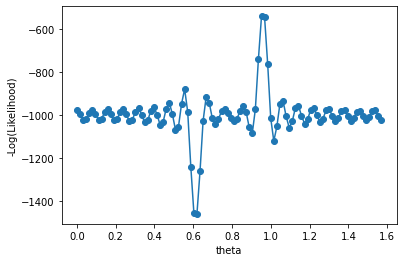

In [30]:
plt.plot(pdf_like['theta'], pdf_like['l_k'], '-o')
plt.xlabel('theta')
plt.ylabel('-Log(Likelihood)')
#plt.ylim(0, 500)

 The strength of the ML-QPE algorithm is in the application of different $m_k$ and try to compute the total **Likelihood**. This can be in the following cells where we apply the launch_optimizer to an increasing number of $m_k$ (first on $m_k$ is selected, then 2 $m_k$ is selected and so on until use all the $m_k$'s for computing likelihood and the correspondiente theta).

In [ ]:
list_of_thetas = []
for i in range(1, len(ml_qae.pdf_mks)):
    step = ml_qae.pdf_mks[:i]
    print(step)
    step_theta = ml_qae.launch_optimizer(step)
    list_of_thetas.append(step_theta)

In [ ]:
plt.plot(list_of_thetas, '-o')
plt.xlabel('number of m_k for optimization')
plt.ylabel('theta')

As can be seen when more $m_k$'s are used more stable is the obtained $\theta$. Additionally increasing the  number of $m_k$'s decreases the error estimation of the $\theta$

In [ ]:
theoric_theta = np.arccos(sum(f_X*p_X)**0.5)
print('theoric_theta: {}'.format(theoric_theta))
AbsolutError = [abs(theta-theoric_theta) for theta in list_of_thetas]

plt.plot(AbsolutError, 'o')
plt.semilogy()

## List of mks

One of the main parameters for the **ML-AE** is the list of $m_k$. For the **MaximumLikelihoodAE** this can be provided as 2 different type of variables:

* Python list: in this case a list of ints in python is provided and the algorithm will be executed following the order of the provided lis.
* Pyhon int: in this case the user provides the maximum number **Max_m_k** of applications and internal python list will be generated from 0 to **Max_m_k-1** in steps of 1 unit and **in reverse order**

In [ ]:
arg_dictionary = {
    'oracle' : pf_gate,
    'list_of_mks': [0, 2, 4, 6, 8],
}
ml_qae = MLAE(**arg_dictionary)

In [ ]:
ml_qae.list_of_mks

In [ ]:
arg_dictionary = {
    'oracle' : pf_gate,
    'list_of_mks': 8,
}
ml_qae = MLAE(**arg_dictionary)

In [ ]:
ml_qae.list_of_mks

Additionally, user can change the provided list by overwriting the *list_of_mks* property of the clas:

In [ ]:
ml_qae.list_of_mks = 20

In [ ]:
print(ml_qae.list_of_mks)